# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds and evaluates a handful of regression models which predict critical reception scores for films. Independent variables include plot synopsis free text, social media metrics on the leading actors, and other categorical variables such as film genre.

In [23]:
import os
import time
# import pickle

import pandas as pd
import numpy as np

import requests

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(style='ticks', color_codes=True)

# import nltk
# from nltk import FreqDist, word_tokenize
# from nltk.stem import WordNetLemmatizer 
# from nltk.corpus import wordnet
# from nltk.corpus import stopwords

# import enchant
# english_d = enchant.Dict("en_US")
# import re
# import gensim
# from gensim import corpora, models, similarities

# import pyLDAvis
# import pyLDAvis.gensim

# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.decomposition import TruncatedSVD
# from sklearn.naive_bayes import MultinomialNB, GaussianNB
# from sklearn import metrics
# from sklearn.metrics import accuracy_score, roc_curve, auc
# from sklearn.dummy import DummyClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.pipeline import Pipeline

# import statsmodels.api as sm
# import statsmodels.formula.api as sm
# import scipy.stats as stats
# from statsmodels.formula.api import ols

# import xgboost as xgb
# from xgboost import XGBClassifier
# from patsy import dmatrices

# Data Collection

## Kaggle Dataset

From https://www.kaggle.com/tmdb/tmdb-movie-metadata:

In [24]:
kaggle_data = pd.read_csv('../data/imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

In [25]:
kaggle_data.shape

(5043, 28)

## Extra Metadata from TheMovieDB.org

One good thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to a third-party API in order to supplement our data with more features. Here we parse out those IMdB ID's:

In [26]:
kaggle_data.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660
5042,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


In [27]:
imdb_ids = kaggle_data['movie_imdb_link'].str[26:35]
imdb_ids[3000:3005]

3000    tt0271259
3001    tt0118901
3002    tt0815178
3003    tt1730687
3004    tt0399095
Name: movie_imdb_link, dtype: object

In [28]:
kaggle_data['imdb_ids'] = imdb_ids

Here we make the API calls, and persist our data to little .json files:

In [29]:
# You will need to enter your own API key in the API_KEY.py file (remove the .template suffix)
from API_KEY import API_KEY

try:
    os.mkdir('../data/movie_metadata')
except FileExistsError:
    pass

__This will make lots of API calls, be warned and use sparingly__, to avoid burning out your API key

In [30]:
# i=0; j=0; total=len(imdb_ids)

# for id in imdb_ids:
#     print(f"Downloading movie {i} of {total}...")
#     i+=1
#     query_string = f'https://api.themoviedb.org/3/movie/{id}?api_key={API_KEY}'
#     json = requests.get(query_string).text
#     if "could not be found" in json:
#         j+=1
#         print(f"{round(j/i, 2)}% of movies not found")
#         continue
#     f = open(f'../data/movie_metadata/movie_{id}.json', 'w+')
#     f.write(json)
#     f.close()

## Combine Kaggle Dataset and TheMovieDB API Responses

In [31]:
tmdb_movies = pd.DataFrame()

for filename in os.listdir(path='../data/movie_metadata/'):
    if "movie" in filename:
        this_movie = pd.read_json(f"../data/movie_metadata/{filename}", lines=True)
        tmdb_movies = pd.concat([this_movie,tmdb_movies], axis=0)

tmdb_movies = tmdb_movies.reset_index(drop=True)

In [32]:
df_merged = tmdb_movies.merge(kaggle_data, 
                              how='left',
                              left_on='imdb_id',
                              right_on='imdb_ids',
                              suffixes=("_kaggle","_api"))

## Munging and EDA

### Keep only desired columns

In [35]:
desired_cols = ("duration adult budget_api budget_kaggle language original_language "
                "production_countries runtime spoken_languages color genres_api "
                "title movie_title original_title overview plot_keywords content_rating "
                "actor_1_facebook_likes actor_2_facebook_likes actor_3_facebook_likes "
                "director_facebook_likes cast_total_facebook_likes facenumber_in_poster "
                "aspect_ratio imdb_score").split()

In [36]:
df_lesscols = df_merged[desired_cols]
df_lesscols.head()

,duration,adult,budget_api,budget_kaggle,language,original_language,production_countries,runtime,spoken_languages,color,...,plot_keywords,content_rating,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,aspect_ratio,imdb_score
0,156.0,False,NaN,10951000,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,...,policeman|stranger|supernatural|village|vomiting,Not Rated,45.0,5.0,0.0,43.0,50,0.0,2.35,7.7
1,102.0,False,NaN,0,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,...,doctor|hospital|mayor|no opening credits|title...,NaN,541.0,8.0,2.0,12.0,553,2.0,NaN,7.2
2,100.0,False,3500000.0,3500000,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,...,NaN,NaN,21.0,3.0,0.0,117.0,24,0.0,NaN,7.0
3,115.0,False,12620000.0,12700000,English,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Color,...,NaN,NaN,14000.0,81.0,29.0,32.0,14133,1.0,NaN,6.8
4,96.0,False,5000000.0,0,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,...,NaN,R,927.0,509.0,503.0,23.0,3552,6.0,NaN,4.5


### Null Values Management

In [37]:
nulls = df_lesscols.isna().sum()[df_lesscols.isna().sum() > 0].sort_values(ascending=False)

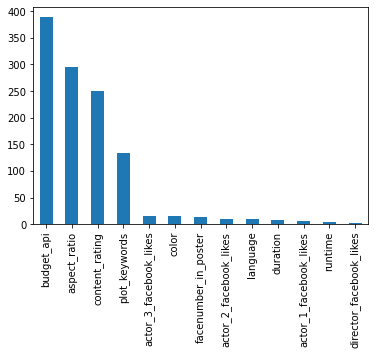

In [38]:
nulls.plot(kind='bar')

In [39]:
df_lesscols[["budget_api", "budget_kaggle"]].head(10)

,budget_api,budget_kaggle
0,NaN,10951000
1,NaN,0
2,3500000.0,3500000
3,12620000.0,12700000
4,5000000.0,0
5,5000000.0,5000000
6,4900000.0,4900000
7,990000.0,0
8,168000.0,0
9,2000000.0,0


Lots of nulls in budget_api, lots of zeroes in budget_kaggle. How best to handle this?

When budget_api is NaN AND budget_kaggle is zero...that's tough. Maybe drop row. Consider imputing median?

In [79]:
# df_lesscols.columns.tolist()

In [86]:
def best_guess_budget(row):
    # When budget_api is NaN and budget_kaggle is non-zero, take budget_kaggle.
    if row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return row['budget_kaggle']
    
    # When budget_api is not NaN but budget_kaggle is zero, take budget_api.
    elif not row.isna()["budget_api"] and row['budget_kaggle'] == 0:
        return row['budget_api']
    
    # When both values are not NaN / non-zero, take the mean?
    elif not row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return np.mean((row['budget_kaggle'], row['budget_api']))
    
    else:
        return None

In [88]:
df_lesscols.head(10).apply(best_guess_budget, axis=1)

0    10951000.0
1           NaN
2     3500000.0
3    12660000.0
4     5000000.0
5     5000000.0
6     4900000.0
7      990000.0
8      168000.0
9     2000000.0
dtype: float64

In [ ]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [ ]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

### One-hot encoding Genres

In [ ]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with everything but Plot Text Features

In [ ]:
main_df = pd.DataFrame()

#join the features we want to narrow in on with our target variable
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

In [ ]:
main_df.columns

In [ ]:
main_df.Year.hist()

In [ ]:
main_df.binary_target.hist()

### Log Transforming "Actor Facebook Likes"

'Actor_1_fb_likes' had some striking outliers and needed a log transform:

In [ ]:
df.Actor_1_fb_likes.hist() # Check out those outliers. Can't even see them...

In [ ]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

In [ ]:
pd.Series(actor_likes).hist() # Much better

Looks way more gaussian after a log transform. We add these logged features to our dataframe:

In [ ]:
main_df = main_df.join(actor_likes)
main_df[:3]

### Baseline Logistic Regression without Plot-Text Features

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [ ]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [ ]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

In [ ]:
main_df.columns

These are the features we're sticking with for now.

### Correlation Matrices

We'd be remiss not to check for overly correlated features:

In [ ]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

In [ ]:
sns.heatmap(main_corr.corr(), center=0);

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

## Using NLP to get features from the Plot Synopses

#### Setting up Lemmatization / Normalization Functions:

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [ ]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [ ]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA; Clustering Documents by Topic

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [ ]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [ ]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

In [ ]:
NUM_TOPICS = 50 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [ ]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

In [ ]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [ ]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

## Joining Topic-Modeled Synopses with Standard Features

In [ ]:
df = main_df.join(tm)
len(df.columns)

## Model Building

In [ ]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train_test_split on X_scaled:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

### Baselining:

In [ ]:
dc = DummyClassifier().fit(X_train, y_train)

In [ ]:
accuracy_score(y_test,dc.predict(X_test))

Dimensionality Reduction with SVD - For the PlotText Data:

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=3, random_state=42)
X_train_pca = pd.DataFrame(svd.fit_transform(X_train))
print(svd.explained_variance_ratio_.sum())

Next we'll try a simple Gaussian Naive Bayes Model:

In [ ]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
y_preds = clf.predict(pd.DataFrame(svd.transform(X_test)))
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

__________

Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

In [ ]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)#pd.DataFrame(svd.transform(X_test)))

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

In [ ]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

In [ ]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
draw_roc_curve(fpr,tpr)

Looks like we're off to an okay start!

## Grid Searching for better parameters

In [ ]:
# svd_components = [100,500,1000]
# itera = [3, 5]

n_est = [50,80,100]
max_depth = [2,3,4]
learning_rates = [.08, .1, .15]

pipe = Pipeline([
#     ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

param_grid = [
    {
#         'reduce_dim__n_components': svd_components,
#         'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_depth,
        'classify__n_jobs': [-1],
        'classify__learning_rate': learning_rates
    }]

score = {'f1': 'f1', 
         'accuracy': 'accuracy'}

grid_adc = GridSearchCV(pipe, 
                        n_jobs=-1, 
                        param_grid=param_grid, 
                        scoring=score, 
                        refit='accuracy',
                        verbose=10)

grid_adc.fit(X_train, y_train)
grid_adc.best_params_

In [ ]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

In [ ]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(10,8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,
         label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Negligible improvement.